In [1]:
%load_ext autoreload
%autoreload 2

## Setup

In [25]:
import jax
import numpy as np
import matplotlib.pyplot as plt 
import galsim as _galsim


In [26]:
jax.__version__, _galsim.__version__


('0.4.16', '2.5.0')

In [137]:
jax.devices()


[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [28]:
jax.config.update("jax_default_device", jax.devices()[0])


In [29]:
import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

from jax import device_get, device_put


In [30]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random


In [31]:
from tqdm import tqdm


In [32]:
import bpd
from bpd.chains import run_chains
from bpd.draw import add_noise


In [33]:
from numpyro.diagnostics import summary, gelman_rubin, effective_sample_size, print_summary


## Forward model

In [256]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
NOISE_FACTOR = 1
BACKGROUND = 1

N_GAL = 2

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 4.5
TRUE_FLUX = 10**LOG_TRUE_FLUX

# positions 
POS = jnp.array([[0.0,0.0],
                 [15.0,0.0]]
               )
 
#shear (per bin)
G = jnp.array([[0.02, 0], 
               [-0.02, 0]]
             )

# which tomographic bin
N_TOMO = 2
TOMO_BINS = jnp.array([0, 1])

LF = jnp.array([LOG_TRUE_FLUX, LOG_TRUE_FLUX]) 
HLR = jnp.array([TRUE_HLR, TRUE_HLR])


assert len(TOMO_BIN) == POS.shape[0] == len(HLR) == len(LF) == N_GAL
assert len(jnp.unique(TOMO_BIN)) == G.shape[0] == N_TOMO



#params
TRUE_PARAMS = {'lfs': LF, 'hlrs': HLR, 'gs': G, 'poss': POS, 'tomo_bins':TOMO_BINS}
# TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}


In [257]:
# get true image
def _draw_gals():
    fim = np.zeros((101,101))
    for ii in range(N_GAL):
        gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
        t = TOMO_BIN[ii]
        gal = gal.shear(g1=G[t, 0], g2=G[t, 1])
        dx, dy = POS[ii]
        pos = _galsim.PositionD(x=dx, y=dy)
        psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
        gal_conv = _galsim.Convolve([gal, psf])
        im = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE, 
                                  offset=pos)
        fim += im.array
    
    mean = fim + BACKGROUND
    noise = np.random.randn(*fim.shape) * np.sqrt(BACKGROUND) * NOISE_FACTOR
    return mean + noise


In [258]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_gals(lfs, hlrs,  gs, poss, tomo_bins):
    fim = jnp.zeros((SLEN, SLEN))
    for ii in range(N_GAL):
        lf = lfs[ii] 
        hlr = hlrs[ii]
        x, y = poss[ii]
        t = tomo_bins[ii]
        g1, g2 = gs[ii]
        
        gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
        gal = gal.shear(g1=g1, g2=g2)
        
        pos = galsim.PositionD(x=x, y=y)
        psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
        gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
        image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                               offset=pos, 
                               )
        fim += image.array
    return fim + BACKGROUND



In [259]:
draw_gals(LF, HLR, G, POS, TOMO_BINS).shape

(101, 101)

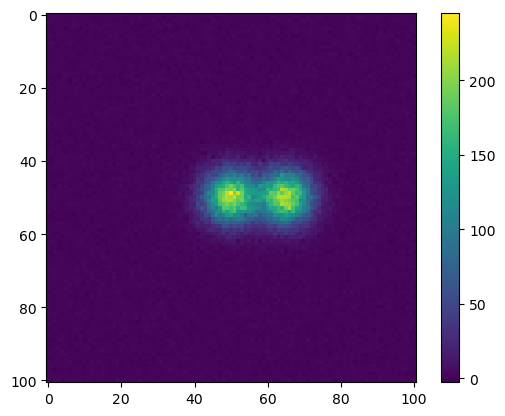

In [260]:
# check error is very small on true thingies
TRUE_IMAGE = _draw_gals()
arr = TRUE_IMAGE 
# - draw_gals(**TRUE_PARAMS)
plt.imshow(arr)
plt.colorbar()


In [261]:
def prob_model(data):
    
    # global shears, one per tomo bin.
    g11 = numpyro.sample('g11', dist.Uniform(-0.1, 0.1))
    g12 = numpyro.sample('g12', dist.Uniform(-0.01, 0.01))
    g21 = numpyro.sample('g21', dist.Uniform(-0.05, 0.05))
    g22 = numpyro.sample('g22', dist.Uniform(-0.01, 0.01))
    g = jnp.array([[g11, g12],[g21,g22]])
 
    with numpyro.plate('b', N_GAL, dim=-1):
        lf = numpyro.sample('lf', dist.Uniform(4,6))
        hlr = numpyro.sample('hlr', dist.Uniform(0.5, 1.5))

    im = draw_gals(lf, hlr, g, POS, TOMO_BINS)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(im)), obs=data)


In [251]:
nuts_kernel = NUTS(prob_model, max_tree_depth=10)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000, num_chains=1)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, data=TRUE_IMAGE)


sample: 100%|██████████| 2500/2500 [00:37<00:00, 66.54it/s, 7 steps of size 5.63e-01. acc. prob=0.89] 


In [252]:
print_summary(mcmc.get_samples(), group_by_chain=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       g11      0.02      0.01      0.02      0.00      0.03   2783.41      1.00
       g12      0.00      0.00      0.01     -0.00      0.01   2381.23      1.00
       g21     -0.02      0.01     -0.02     -0.03     -0.01   2808.13      1.00
       g22     -0.00      0.00     -0.00     -0.01      0.00   2861.37      1.00
    hlr[0]      0.90      0.01      0.90      0.89      0.91   2369.38      1.00
    hlr[1]      0.90      0.01      0.90      0.88      0.91   2638.24      1.00
     lf[0]      4.50      0.00      4.50      4.49      4.50   2703.69      1.00
     lf[1]      4.50      0.00      4.50      4.49      4.50   2637.21      1.00



In [253]:
samples = mcmc.get_samples()

In [254]:
samples['g11'].mean(), samples['g21'].mean()

(Array(0.01715926, dtype=float32), Array(-0.01810854, dtype=float32))

Parameter g11 in chain Posterior is not constrained


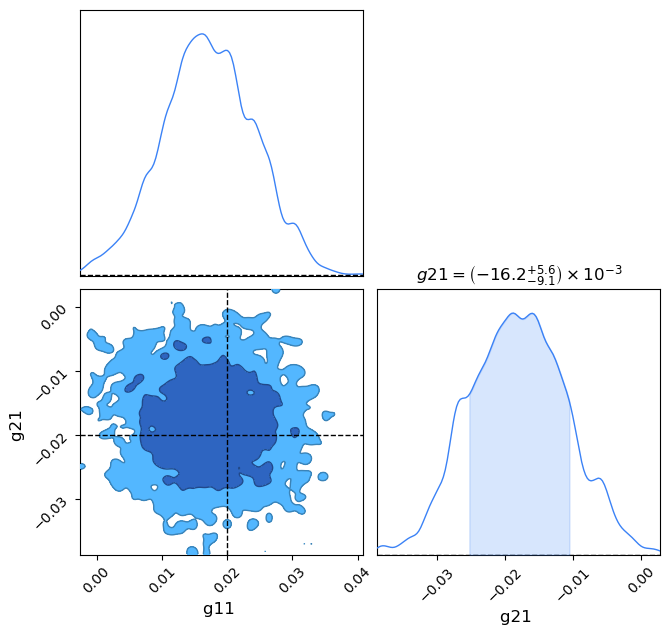

In [255]:
# example of corner plots
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
samples = {k:samples[k] for k in ['g11', 'g21']}
df =pd.DataFrame.from_dict(samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location={'g11':0.02, 'g21':-0.02}))
fig = c.plotter.plot()